In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [8]:
class VRPTW:
    # Differential Evolution (DE) optimizer wrapper for VRPTW.
    # - Genome is real-valued; the first block decodes to a customer order (via argsort),
    #   the last 'num_vehicles' genes decode to a vehicle ordering/indexing.
    # - Fitness is computed by 'preserving_strategy' (your VRPTW cost/feasibility evaluator).

    # --------------------------
    # Hyper-params and problem data
    # --------------------------
    def __init__(
        self,
        population_size,
        dimensions,
        bounds,
        distance,
        demand,
        readyTime,
        dueDate,
        serviceTime,
        vehicle,
        # DE parameter bounds (F and CR must stay within these ranges)
        F_bounds=[1e-5, 1],  ### wide range (bounds)
        CR_bounds=[1e-5, 1],  ### wide range (bounds)
    ):
        # ----- Inputs -----
        self.population_size = population_size  # population size for DE
        self.dimensions = dimensions  # chromosome length
        self.bounds = bounds  # per-gence[low, high], shape=(dimensions, 2)
        self.F_rate = None  # DE mutation factor
        self.CR_rate = None  # DE crossover rate
        self.MG_rate = None  # migration rate (fraction of elites)
        self.distance = distance  # time/distance matrix (inclues depot=0)
        self.demand = demand  # node demand
        self.readyTime = readyTime  # ready times
        self.dueDate = dueDate  # due times
        self.serviceTime = serviceTime  # service times
        self.vehicle = vehicle  # [num_vehicle, vehicle_per_vehicle]

        # ----- Internals -----
        self.global_solution_history = []  # best fitness per iteration
        self.current_cost = np.array([])  # fitness for the current generation

        # kwargs passed into objective/preserving_strategy
        self.kwargs = {
            "distance": distance,
            "demand": demand,
            "readyTime": readyTime,
            "dueDate": dueDate,
            "serviceTime": serviceTime,
            "vehicle": vehicle,
        }

        # Derived/other internal state
        self.population = None
        self.mutation_bounds = F_bounds
        self.crossover_bounds = CR_bounds

        # Step sizes when adjusting F/CR with 'action'
        self.F_rate_increment = 0.1
        self.CR_rate_increment = 0.1

        # Convergence rate
        self.percent_convergence = None

        # Counting iteration
        self.count_total_iteration = None
        self.convergence_cost = []

        # Standard Deviation
        self.DE_robust = None
        self.std_pop = None

    # --------------------------
    # Initialize population and DE params
    # --------------------------
    def reset(self):
        # Random uniform initialization within per-gene bounds
        self.population = np.random.uniform(
            self.bounds[:, 0],
            self.bounds[:, 1],
            (self.population_size, len(self.bounds)),
        )

        # Reasonable default rates
        self.MG_rate = 0.5
        self.F_rate = (self.mutation_bounds[0] + self.mutation_bounds[1]) / 2
        self.CR_rate = (self.crossover_bounds[0] + self.crossover_bounds[1]) / 2
        self.count_total_iteration = 0
        self.global_solution_history = []  # best fitness per iteration
        self.DE_robust = None

    # --------------------------
    # VRPTW cost evaluator (your original logic kept intact)
    # --------------------------
    def preserving_strategy(self, X, V, **kwargs):
        # --- Unpack input data from keyword arguments ---
        dist = kwargs["distance"]  # Distance/time matrix between all nodes
        weight = kwargs["demand"]  # Demand (weight) for each customer node
        ready = kwargs["readyTime"]  # Ready time (earliest service time) for each node
        due = kwargs["dueDate"]  # Due time (latest service time) for each node
        service = kwargs["serviceTime"]  # Service time at each node
        vehicle = kwargs[
            "vehicle"
        ]  # Vehicle info: [number of vehicles, capacity per vehicle]

        # Get per-vehicle capacities (by indexing with V)
        pre_w_cap = np.array([vehicle[1]] * vehicle[0])
        w_cap = pre_w_cap[V]

        # -- Initialization --
        sequence = X  # Route sequence (includes depot at start & end)
        n_cust = len(sequence) - 2  # Number of customers (not counting depot nodes)
        n_veh = vehicle[0] - 1  # Number of vehicles - 1 (for indexing)
        i, k = 0, 0  # i: current position in sequence, k: vehicle index
        total_distance = 0  # Store total traveled distance (with penalty if any)

        # -- Main loop over each vehicle route --
        while k <= n_veh and i <= n_cust:
            # Initialize per-route accumulators
            route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

            if k > 0:
                i += 1  # Move to the next start customer for the next vehicle
            # Start route: depot to first customer
            route_dist += dist[0][sequence[i]]  # Distance depot -> first customer
            route_time += (
                service[0] + dist[0][sequence[i]]
            )  # Service + travel time to first customer
            weight_load += weight[sequence[i]]  # Initial cargo: first customer demand

            if route_time < ready[sequence[i]]:
                route_time = ready[
                    sequence[i]
                ]  # Wait if vehicle arrives before ready time

            if route_time > due[sequence[i]] or weight_load > w_cap[k]:
                penaltyCost += 1e11  # Penalty: arrived after due time (infeasible)
                break

            # --- Continue visiting customers along this route ---
            while i <= n_cust:
                route_dist += dist[sequence[i]][
                    sequence[i + 1]
                ]  # Add next leg distance
                route_time += (
                    service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                )  # Add service + travel time
                weight_load += weight[sequence[i + 1]]  # Add new customer demand

                if route_time < ready[sequence[i + 1]]:
                    route_time = ready[
                        sequence[i + 1]
                    ]  # Wait if arrive early at next node

                # If time window or capacity violated, backtrack and finish route
                if route_time > due[sequence[i + 1]] or weight_load > w_cap[k]:
                    route_dist -= dist[sequence[i]][sequence[i + 1]]
                    route_time -= (
                        service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                    )
                    weight_load -= weight[sequence[i + 1]]
                    break
                i += 1

            # --- Finish by returning to depot ---
            route_dist += dist[sequence[i]][0]  # Add distance to depot
            route_time += (
                service[sequence[i]] + dist[sequence[i]][0]
            )  # Add service at last node + travel to depot
            if route_time > due[0]:
                penaltyCost += 1e11  # Penalty: returned to depot too late
            # Accumulate this route's total (distance + penalty if any)
            total_distance += route_dist + penaltyCost
            k += 1  # Next vehicle

        return total_distance  # Return overall objective (distance with penalty if violated)

    # --------------------------
    # Thin wrapper to call the evaluator
    # --------------------------
    def f_per_particle(self, m, s, **kwargs):
        X = m  # decoded sequence
        V = s  # decoded vehicle vector
        obj_val = self.preserving_strategy(X, V, **kwargs)  # Call Preserving strategy.
        return obj_val

    # --------------------------
    # Decode a chromosome to (sequence, vehicle) and evaluate
    # --------------------------
    def objective_func(self, x, **kwargs):
        vehicle = kwargs["vehicle"]
        # First block → customer order (rank-based decoding): smaller value → earlier visit
        seq = x[: -vehicle[0]].argsort() + 1
        # Last 'num_vehicles' genes → vehicle order/index (again rank-based)
        sort = x[-vehicle[0] :].argsort()
        j = self.f_per_particle(seq, sort, **kwargs)
        return np.array(j)

    # --------------------------
    # Main DE loop
    # --------------------------
    def evolve(self, n_iteration):
        population_size = self.population_size
        bounds = self.bounds

        self.convergence_cost = []
        for _ in range(n_iteration):
            self.current_cost = np.array([])
            self.count_total_iteration += 1

            for i in range(population_size):
                # ---- Mutation (DE/rand/1) ----
                indices = [idx for idx in range(population_size) if idx != i]
                a, b, c = self.population[np.random.choice(indices, 3, replace=False)]
                mutant = self.population[i] + self.F_rate * (b - c)

                # (Optional) You might want to clip mutant to bounds to avoid runaway values:
                # mutant = np.clip(mutant, bounds[:, 0], bounds[:, 1])

                # ---- Crossover (binomial) ----
                crossover_prob = np.random.rand(len(bounds))
                trial = np.where(
                    crossover_prob < self.CR_rate, mutant, self.population[i]
                )

                # Note: In classic DE, we ensure at least one dimension from the mutant (jrand trick).
                # Todo: enforce jrand if you want strict DE semantics.

                # ---- Selection ----
                fitness_trial = self.objective_func(trial, **self.kwargs)
                fitness_current = self.objective_func(self.population[i], **self.kwargs)

                if fitness_trial < fitness_current:
                    self.population[i] = trial
                    self.current_cost = np.insert(
                        self.current_cost, len(self.current_cost), fitness_trial
                    )
                else:
                    self.current_cost = np.insert(
                        self.current_cost, len(self.current_cost), fitness_current
                    )

            # Track the best-so-far (scalar) after each iteration
            self.global_solution_history.append(self.get_best_solution())
            self.convergence_cost.append(self.get_best_solution())

    def migration(self):
        # Keep the top MG_rate fraction from the current population and
        # inject them into the worst positions of a freshly sampled population.

        # Best indices from the current population
        idx_best_migration = self.current_cost.argsort()[
            : int(self.population_size * self.MG_rate)
        ]
        migration_population = self.population[idx_best_migration]

        # New random population
        new_pop = np.random.uniform(
            self.bounds[:, 0],
            self.bounds[:, 1],
            (self.population_size, len(self.bounds)),
        )

        # Evaluate new population
        migration_cost = np.array([])
        for obj in range(self.population_size):
            migration_cost = np.insert(
                migration_cost,
                len(migration_cost),
                self.objective_func(new_pop[obj], **self.kwargs),
            )

        # Replace the worst in the new population with previous elites
        idx_good_migration = migration_cost.argsort()
        idx_bad_migration = np.flip(idx_good_migration)[
            : int(self.population_size * self.MG_rate)
        ]
        new_pop[idx_bad_migration] = migration_population

        # Adopt the migrated population
        self.population = new_pop

    # --------------------------
    # Adjust migration rate
    # --------------------------
    def change_migration_rate(self, migration_rate):
        self.MG_rate = migration_rate

    def action(self, option):
        match option:
            case "F0CR0":
                pass
            case "F+CR0":
                self.F_rate += self.F_rate_increment
            case "F-CR0":
                self.F_rate -= self.F_rate_increment
            case "F0CR+":
                self.CR_rate += self.CR_rate_increment
            case "F0CR-":
                self.CR_rate -= self.CR_rate_increment
            case "F+CR+":
                self.F_rate += self.F_rate_increment
                self.CR_rate += self.CR_rate_increment
            case "F+CR-":
                self.F_rate += self.F_rate_increment
                self.CR_rate -= self.CR_rate_increment
            case "F-CR+":
                self.F_rate -= self.F_rate_increment
                self.CR_rate += self.CR_rate_increment
            case "F-CR-":
                self.F_rate -= self.F_rate_increment
                self.CR_rate -= self.CR_rate_increment
            # -----------ADD---------------
            # -----------------------------
            case "MG0":
                self.MG_rate = 0
                self.migration()
            # -----------------------------
            # -----------------------------
            case "MG10":
                self.MG_rate = 0.1
                self.migration()
            case "MG25":
                self.MG_rate = 0.25
                self.migration()
            case "MG50":
                self.MG_rate = 0.5
                self.migration()
            case _:
                raise Exception("Unknown option")
        # Keep F and CR within user-specified bounds
        self.check_FCR()

    # --------------------------
    # Clamp F and CR to their bounds (by step nudging)
    # --------------------------
    def check_FCR(self):
        if self.F_rate < self.mutation_bounds[0]:
            self.F_rate += self.F_rate_increment

        if self.CR_rate < self.crossover_bounds[0]:
            self.CR_rate += self.CR_rate_increment

        if self.F_rate > self.mutation_bounds[1]:
            self.F_rate -= self.F_rate_increment

        if self.CR_rate > self.crossover_bounds[1]:
            self.CR_rate -= self.CR_rate_increment

    # --------------------------
    # Utility: standard deviation of the latest population fitnesses
    # --------------------------
    # standard deviation from population in same iteration
    # -------10 Replication (Next part) ---------

    def robustness(self, solution):
        #     # Return the std of current generation's fitness values.
        #     # Note: call 'evolve()' at least once so 'current_cost' is populated.
        self.DE_robust = np.std(solution)

    def std_population(self):
        self.std_pop = np.std(self.current_cost)

    # ------------------------------
    # ------------------------------
    def convergence_rate(self, n_iteration):
        start = self.global_solution_history[self.count_total_iteration - n_iteration]
        end = self.global_solution_history[-1]
        self.percent_convergence = abs(start - end) / n_iteration

    # def convegence_rate(self, current_iteration):
    #    self.percent_convergence = (self.convergence_cost[0] - self.convergence_cost[-1]) / current_iteration
    # local convergence rate : 100 itertion
    # (Start - finished) / number of iteration (100)
    # EX. self.global_solution_history[:] / number of iteration
    # -----------------------------
    # -----------------------------

    # --------------------------
    # Introspection helpers
    # --------------------------
    def get_current_state(self):
        # Returns DE hyper-parameters and the latest best fitness (scalar).
        return {
            "F": self.F_rate,
            "CR": self.CR_rate,
            "MG": self.MG_rate,
            "Best_solution": self.global_solution_history[-1],
        }

    def get_best_solution(self):
        # Evaluate and return the best fitness among current population
        # as a scalar float. (Flattens to handle 0-d arrays.)

        # Evaluate the objective value for each individual in the population.
        obj_values = [
            self.objective_func(ind, **self.kwargs) for ind in self.population
        ]

        # Find the index of the individual with the lowest (best) objective value.
        best_index = np.argmin(obj_values)

        # Get the best objective value and the corresponding individual (solution).
        best_solution = obj_values[best_index]
        best_position = self.population[best_index]

        # return best_solution, best_position
        # Note  : for some reason, the best_solution has zero dimension. I need to convert to float.
        return best_solution.flatten()[0]


# ToDO:
# [x] 1. Convergence_rate :
# [x] 2. check_FCR cannot exceed bounds
# def change_F(self, mode):
# if mode == "INCREASE":
#     self.F += self.delta_F
# elif mode == "DECREASE":
#     self.F -= self.delta_F
#     if self.F < 0:
#         self.F += self.delta_F  # Return to previous value
# else:
#     raise Exception("Invalid Option")

# [x] 3. Standard Deviation
# [x] 4. Number of iteration : self.counter += 1
# [ ] 5. Source : only data for running (Easy)

In [9]:
# Load file
distance = (
    pd.read_excel(
        r"C:\rl-meta-test\src\Source\rl_meta_test_data.xlsx", sheet_name="distance"
    ).fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_excel(r"C:\rl-meta-test\src\Source\rl_meta_test_data.xlsx", sheet_name='vehicle')
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_excel(r"C:\rl-meta-test\src\Source\rl_meta_test_data.xlsx", sheet_name="customer").iloc[:, 3:]
demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, -1].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

dimensions = len(distance) - 1 + vehicle[0]
maxiters = 10
population_size = 4
bounds = np.array([[0, 1]] * dimensions)
F_rate = 0.5
CR_rate = 0.5
MG_rate = 0.5


vrptw = VRPTW(
    population_size=population_size,
    dimensions=dimensions,
    bounds=bounds,
    distance=distance,
    demand=demand,
    readyTime=readyTime,
    dueDate=dueDate,
    serviceTime=serviceTime,
    vehicle=vehicle,
)


In [10]:
vrptw.reset()
start = time.time()
vrptw.evolve(n_iteration=maxiters)
end = time.time()
computational_time = end - start
print(f'Computational time : {computational_time} second')

Computational time : 0.02791738510131836 second


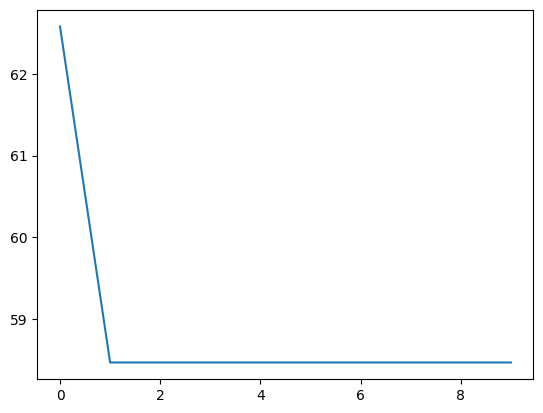

In [11]:
plt.plot(vrptw.global_solution_history)

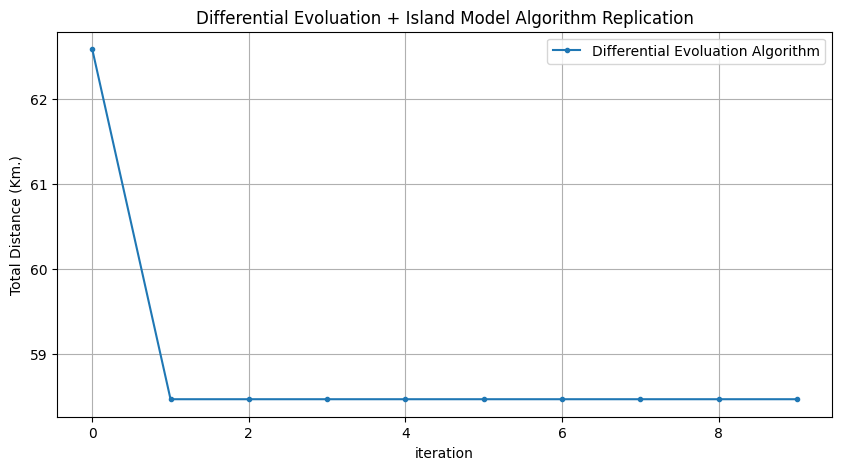

In [12]:
Replication = [i for i in range(len(vrptw.global_solution_history))]
y1 = vrptw.global_solution_history
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(Replication, y1, marker=".", label="Differential Evoluation Algorithm")
ax.set(
    xlabel="iteration",
    ylabel="Total Distance (Km.)",
    title="Differential Evoluation + Island Model Algorithm Replication",
)
ax.grid()
ax.legend()
plt.show()